In [ ]:
from dataclasses import dataclass
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
import math
import time

In [ ]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.SCALE = 1

        self.n_head = config.n_head
        self.n_embd = config.n_embd

        #self.mask = torch.tril(torch.ones(config.context_length, config.context_length)).view(1, 1, config.context_length, config.context_length).to(config.device)

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimension
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # batch size, num heads, sequence length, embedding size
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # att = (q @ k.transpose(-2, -1)) * 1.0 / math.sqrt(k.size(-1))
        # att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.SCALE = 1

    def forward(self, x):
        return self.c_proj(self.gelu(self.c_fc(x)))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    context_length: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    device: str = 'cuda'

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.context_length, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing
        self.transformer.wte.weight = self.lm_head.weight   

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, "SCALE"):
                std *= (2 * self.config.n_layer) ** -0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.context_length
        pos = torch.arange(0, T, dtype=torch.long, device = idx.device)
        pos_emb = self.transformer.wpe(pos)
        tok_emb = self.transformer.wte(idx)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
         
        x - self.transformer.ln_f(x)
        logits = self.lm_head(x) # B, T, vocab_size
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    
    def configure_optimizers(self, weight_decay, learning_rate):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}

        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params' : decay_params, 'weight_decay' : weight_decay},
            {'params' : nodecay_params, 'weight_decay' : 0.0}
        ]

        return torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8)


In [ ]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        with open("shakespeare.txt", 'r') as f:
            text = f.read()
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        self.curent_pos = 0

        print(f"1 epoch is {len(tokens) // (B * T)} batches")

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.curent_pos:self.curent_pos + B*T + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)

        self.curent_pos += B*T
        if self.curent_pos + (B * T + 1) > len(self.tokens):
            self.curent_pos = 0
        return x,  y



In [ ]:
device = "cuda"
model = GPT(GPTConfig(vocab_size=50304)).to(device)


In [ ]:
torch.set_float32_matmul_precision('high')

max_lr = 12e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50
val_check_freq = 50

def get_lr(it):
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    if it > max_steps:
        return min_lr
    decay_ration = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ration <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ration))
    return min_lr + coeff * (max_lr - min_lr)

total_batch_size = 2 ** 19
B = 4
T = 1024
assert total_batch_size % (B * T) == 0
grad_accum_steps = total_batch_size // (B * T)
print(f"grad accum steps = {grad_accum_steps}")
loader = DataLoaderLite(B, T)

optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4)
for step in range(max_steps):
    t1 = time.time()
    loss_accum = 0.0
    if step % val_check_freq == 0 or step == max_steps - 1:
        checkpoint = {
            'model' : model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'config' : model.config,
            'step' : step,
        }
    for micro_step in range(grad_accum_steps):
        x, y = loader.next_batch()
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss /= grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    norm = nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t2 = time.time()
    dt = (t2 - t1) * 1000
    tok_per_sec = (loader.B * loader.T * grad_accum_steps) / (t2 - t1)
    print(f"step {step} | loss: {loss_accum} | norm: {norm:.4f} | lr: {lr:.4e} | time: {dt} | tokens / second: {tok_per_sec}")

In [ ]:
# enc = tiktoken.get_encoding('gpt2')
# tokens = enc.encode("A strike is a")
# x = torch.tensor(tokens, dtype=torch.long).to(device)
# x = x.unsqueeze(0)
# max_length = 30
# while x.size(1) < max_length:
#     with torch.no_grad():
#         logits = model(x)
#         logits = logits[:, -1, :]
#         probs = F.softmax(logits, dim=-1)
#         topk_probs, topk_indicies = torch.topk(probs, 50, dim=-1)
#         ix = torch.multinomial(topk_probs, 1)
#         xcol = torch.gather(topk_indicies, -1, ix)
#         x = torch.cat((x, xcol), dim=1)

# tokens = x[-1].tolist()
# print(enc.decode(tokens))

In [16]:
import tiktoken
import torch
from model.gpt import *
import torch.nn.functional as F


checkpoint = torch.load('model/finetuned.pth')
device = "cuda"

model = GPT(GPTConfig(vocab_size=50304)).to(device)

# Restore the model state
model.load_state_dict(checkpoint['model'])


enc = tiktoken.get_encoding('gpt2')
start = "Who created you?"
tokens = enc.encode(start)
print(start)
x = torch.tensor(tokens, dtype=torch.long).to(device)
x = x.unsqueeze(0)
max_length = len(start) + 10000
while x.size(1) < max_length:
    with torch.no_grad():
        logits, loss = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indicies = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        xcol = torch.gather(topk_indicies, -1, ix)
        x = torch.cat((x, xcol), dim=1)
        next_char = xcol.squeeze(0).tolist()
        if xcol.squeeze(0).tolist() == [50256]:
            break
        print(enc.decode(next_char), end='')

Who created you?
 In the beginning, the term "creative commons" refers to the arrangement of ideas in a social context. This implies the ability to collaborate, innovate, or invent new ideas. Additionally, the concept is also associated with the concept of social justice. It's a philosophy that recognizes the importance of fairness, consent, and respect for all individuals, regardless of political, religious, or social norms.

In [ ]:
from datasets import load_dataset
import pickle

dataset = load_dataset("berkeley-nest/Nectar")

qa_pairs = []

for entry in dataset['train']:
    question = entry['prompt']
    question = question.split('Human:')[1].split('\n\nAssistant:')[0].strip()
    answers = entry['answers']
    for answer in answers:
        ans = answer['answer']
        if ans != """I'm sorry, but I can't assist with that.""":
            tokens = enc.encode(question + ' ' + ans + '<|endoftext|>', allowed_special={'<|endoftext|>'})
            if len(tokens) <= 1024:
                qa_pairs.append(tokens)

with open('qa_pairs.pkl', 'wb') as f:
    pickle.dump(qa_pairs, f)

In [ ]:
import random
import pickle
with open('qa_pairs.pkl', 'rb') as f:
    pairs = pickle.load(f)
random.shuffle(pairs)

with open('qa_pairs.pkl', 'wb') as f:
    pickle.dump(pairs, f)


In [ ]:
print(len(pairs) * .001)

In [ ]:
# from tqdm import tqdm
# new_pairs = []
# for pair in tqdm(pairs):
#     raw_text = pair[0] + ' ' + pair[1]
#     tokens = enc.encode(raw_text, allowed_special={'<|endoftext|>'})
#     if len(tokens) <= 1024:
#         new_pairs.append(tokens)

# with open('qa_pairs.pkl', 'wb') as f:
#     pickle.dump(new_pairs, f)

In [ ]:
import random
import torch
import pickle

with open('qa_pairs.pkl', 'rb') as f:
    data = pickle.load(f)


In [11]:
from datasets import load_dataset
import pickle
import tiktoken 

enc = tiktoken.get_encoding('gpt2')

dataset = load_dataset("caball21/baseball")

qa_pairs = []

for entry in dataset['train']:
    question = entry['input']
    instruct = entry['instruction']
    answer = entry['output']
    if answer is None or question is None or instruct is None:
        continue
    combined = question + ' ' + instruct + ' ' + answer + "<|endoftext|>"
    qa_pairs.append(enc.encode(combined, allowed_special={"<|endoftext|>"}))

with open('baseball_pairs.pkl', 'wb') as f:
    pickle.dump(qa_pairs, f)


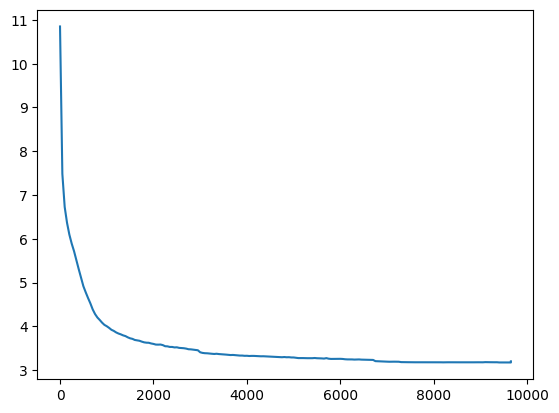

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

with open("validation_loss_log.txt", "r") as f:
    data = f.readlines()

x = []
y = []
for line in data:
    x.append(int(line.split()[0]))
    y.append(float(line.split()[-1]))

plt.plot(x, y)


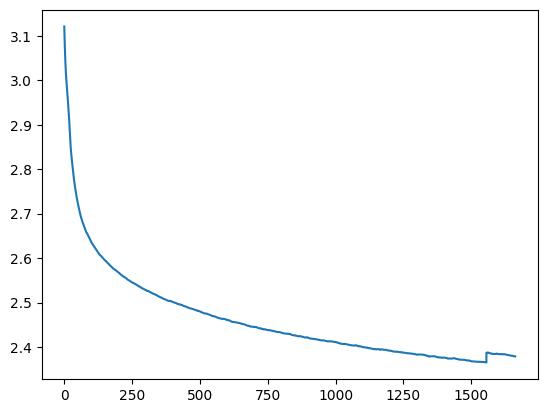

In [16]:
with open("validation_finetuning_loss_log.txt", "r") as f:
    data = f.readlines()

x = []
y = []
for line in data:
    x.append(int(line.split()[3]))
    y.append(float(line.split()[-1]))

plt.plot(x, y)


('input', 'Player 1: Tom Seaver\nStatcast Data: Spin Rate: 2,559 RPM, Spin Axis: -28.7 degrees\n\nPlayer 2: Cliff Lee\nStatcast Data: Spin Rate: 2,418 RPM, Spin Axis: -7.2 degrees')
('output', "Tom Seaver and Cliff Lee have distinct pitching techniques, as indicated by their Statcast data. Seaver has a higher spin rate of 2,559 RPM compared to Lee's 2,418 RPM. A higher spin rate can contribute to increased movement on pitches, making them more difficult for batters to hit. However, the actual movement also depends on the pitch type and release point.\n\nRegarding spin axis values, Seaver has a more extreme negative spin axis of -28.7 degrees, while Lee's spin axis is -7.2 degrees. A spin axis value can provide insights into the pitch's movement direction, with a negative value indicating a clockwise rotation and a positive value indicating counterclockwise rotation. It's essential to consider the specific pitch types thrown by each player to better understand the implications of these 